## 1 Prepare data

In [157]:
from scipy import stats
import numpy as np
import pandas as pd
import wrangle as wr
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, HTML

#talos items
import talos as ta
from talos.metrics.keras_metrics import fmeasure_acc
from talos import live

# Keras items
from keras import backend as K
from keras.optimizers import Adam, Nadam
from keras.activations import relu, elu
from keras.losses import binary_crossentropy
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dropout, Dense
from keras.models import model_from_json


In [46]:
attrs=[]
attr_types={}
with open('communities.attrs','r') as g:
    attr=g.readline()
    while attr:
        redundant,attr,cat=attr.split()
        if cat not in attr_types:
                attr_types[cat]=set()
        attr_types[cat].add(attr)
        attrs.append(attr)
        attr=g.readline()

A=[]
index=[]
def convert(i):
    try:
        return float(i)
    except:
        return -1.
    
with open("communities.data", "r") as f:
    data=f.readline()
    while data:
        x=data.split(',')
        x[-1]=x[-1][:-1]
        index.append(x[3])
        data=f.readline()
        A.append([convert(i) for i in x])
    
data=pd.DataFrame.from_records(A, index=index, columns=attrs)
data.head(10)
#data is dataframe indexed by 'communityname' each enry has 128 numeric entry 
#with ''ViolentCrimesPerPop' be the target of regrssion

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
Lakewoodcity,8.0,-1.0,-1.0,-1.0,1.0,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
Tukwilacity,53.0,-1.0,-1.0,-1.0,1.0,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,-1.00,-1.00,-1.0,-1.0,0.00,-1.00,0.67
Aberdeentown,24.0,-1.0,-1.0,-1.0,1.0,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,-1.00,-1.00,-1.0,-1.0,0.00,-1.00,0.43
Willingborotownship,34.0,5.0,81440.0,-1.0,1.0,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,-1.00,-1.00,-1.0,-1.0,0.00,-1.00,0.12
Bethlehemtownship,42.0,95.0,6096.0,-1.0,1.0,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,-1.00,-1.00,-1.0,-1.0,0.00,-1.00,0.03
SouthPasadenacity,6.0,-1.0,-1.0,-1.0,1.0,0.02,0.28,0.06,0.54,1.00,...,0.01,0.58,0.10,-1.00,-1.00,-1.0,-1.0,0.00,-1.00,0.14
Lincolntown,44.0,7.0,41500.0,-1.0,1.0,0.01,0.39,0.00,0.98,0.06,...,0.05,0.08,0.06,-1.00,-1.00,-1.0,-1.0,0.00,-1.00,0.03
Selmacity,6.0,-1.0,-1.0,-1.0,1.0,0.01,0.74,0.03,0.46,0.20,...,0.01,0.33,0.00,-1.00,-1.00,-1.0,-1.0,0.00,-1.00,0.55
Hendersoncity,21.0,-1.0,-1.0,-1.0,1.0,0.03,0.34,0.20,0.84,0.02,...,0.04,0.17,0.04,-1.00,-1.00,-1.0,-1.0,0.00,-1.00,0.53
Claytoncity,29.0,-1.0,-1.0,-1.0,1.0,0.01,0.40,0.06,0.87,0.30,...,0.00,0.47,0.11,-1.00,-1.00,-1.0,-1.0,0.00,-1.00,0.15


In [79]:
target='ViolentCrimesPerPop'
x=data.drop(target, 1).values
y=data[target].values
total=len(data[target])
split=int(total*0.2)
x_test=x[:split]
y_test=y[:split]
x=x[split:]
y=y[split:]
rest_total=len(x)
split=int(rest_total*0.2)
x_val=x[:split]
y_val=y[:split]
x_train=x[split:]
y_train=y[split:]
#split .2 of total data for testing split .2 of rest data for validating rest is for training
len(x_train),len(x_val),len(x_test)

(1277, 319, 398)

## 2. Creating the Keras Model

In [97]:
# first we have to make sure to input data and params into the function
# def breast_cancer_model(x_train, y_train, x_val, y_val, params):

#     model = Sequential()
#     model.add(Dense(params['first_neuron'], input_dim=x_train.shape[1],
#                     activation=params['first_activation'],
#                     kernel_initializer=params['kernel_initializer']))
    
#     model.add(Dense(params['second_neuron'], activation=params['activation']))
#     model.add(Dropout(params['dropout']))

#     model.add(Dense(1, activation=params['last_activation']
#                     ))
    
#     model.compile(loss=params['losses'],
#                   optimizer=params['optimizer'](),
#                   metrics=['acc', fmeasure_acc])
    
#     history = model.fit(x_train, y_train, 
#                         validation_data=[x_val, y_val],
#                         batch_size=params['batch_size'],
#                         callbacks=[live()],
#                         epochs=params['epochs'],
#                         verbose=0)

#     return history, model

def crime_model(x_train, y_train, x_val, y_val, p):
    
    #print("Val size",np.shape(x_val))
    model = Sequential()
    model.add(Dense(p['first_neuron'], input_dim=x_train.shape[1],
                    activation=p['first_activation'],
                    kernel_initializer=p['kernel_initializer']))
    for i in range(p['hidden_layer']):
        model.add(Dense(p['hidden_neuron'], activation=p['activation']))
    #model.add(Dropout(params['dropout']))

    model.add(Dense(1, activation=p['last_activation']
                    ))
    def r_value( y_true,y_pred):###actually returns 1-r
        return 1-K.mean(normalize(y_true)*normalize(y_pred))
    def normalize(x):
        return K.batch_normalization(x,K.mean(x),K.var(x),beta=0,gamma=1)
    model.compile(loss=p['losses'],
                  optimizer=p['optimizers'],
                  metrics=[r_value])
    
    history = model.fit(x_train, y_train, 
                        validation_data=(x_val, y_val),
                        callbacks=[live()],
                        epochs=p['epochs'],
                        verbose=0)
   # print("Val size",np.shape(x_val),np.shape(y_val))

    return history, model



In [129]:
# run this code just once
best_param_each_round={}
data_each_round={}

## 3. Defining the Parameter Space Boundary

In [138]:
# set the parameter space
para_spaces=[]
#test para space for the first round:
p1={
    'first_neuron':[10],
    'first_activation':['relu'],
    'hidden_layer':[3],
     'hidden_neuron':[8],
     'batch_size': [30],
     'epochs': [40],
     'kernel_initializer': ['normal'],
     'optimizers': ['Adam'],
     'losses': ['MSE'],
     'activation':['relu'],
     'last_activation': ['linear']
  }
para_spaces.append(p1) 

#test para space for the first round:
p2={
    'first_neuron':[6,12],
    'first_activation':['relu'],
    'hidden_layer':[0,1,2],
     'hidden_neuron':[8],
     'batch_size': [20,40],
     'epochs': [20,40],
     'kernel_initializer': ['normal'],
     'optimizers': ['Adam'],
     'losses': ['MSE'],
     'activation':['relu'],
     'last_activation': ['linear']
  }
para_spaces.append(p2)

# base on exp 1 hidden layer should be 0 or 1, epochs is good,now try to vary batch size and kernel init
# p2={'first_neuron':[2,6,10],
#     'first_activation':['relu'],
#     'hidden_layer':[0,1],
#      'hidden_neuron':[2,5,8],
#      'batch_size': [20,40],
#      'epochs': [40],
#      'kernel_initializer': ['normal','uniform'],
#      'losses': ['MSE'],
#      'activation':['relu'],
#      'last_activation': ['linear'],
#    'dropout': [0]}
# best val_r_value is 0.296 corresopind to r-sqrued 0.574

# base on exp2 10 first neuon 0 hiddenlayer 20 batchsize normal kernel initializer will be prefferd.
# p3={'first_neuron':[10],
#     'first_activation':['relu','linear'],
#     'hidden_layer':[0],
#      'hidden_neuron':[2],
#      'batch_size': [20],
#      'epochs': [40],
#      'kernel_initializer': ['normal'],
#      'losses': ['MSE'],
#      'activation':['relu'],
#      'last_activation': ['linear'],
#     'optimizers': ["SGD",'RMSprop','Adagrad','Adadelta','Adam','Nadam'],
#    'dropout': [0]}

## 4. Starting the Experiment

In [160]:
exp_round=2

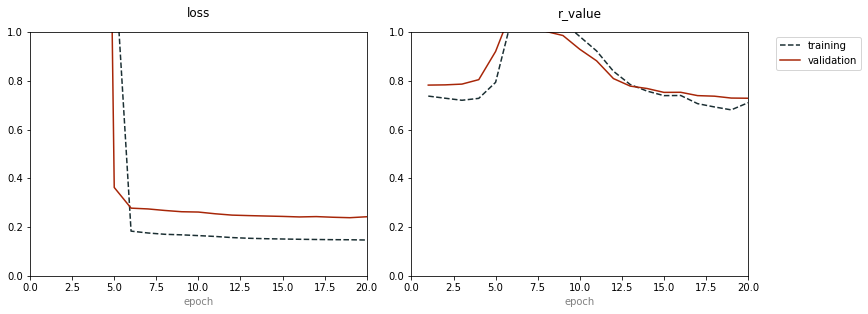




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [03:59<00:00,  8.33s/it]

Scan Finished!


,round_epochs,val_loss,val_r_value,loss,r_value,first_neuron,first_activation,hidden_layer,hidden_neuron,batch_size,epochs,kernel_initializer,optimizers,losses,activation,last_activation
0,40,0.0684774060234,0.490008760956,0.0460115776761,0.511794450233,6,relu,1,8,40,40,normal,Adam,MSE,relu,linear
1,20,0.0711563492667,0.792026996986,0.0524754652647,0.775471080068,12,relu,2,8,20,20,normal,Adam,MSE,relu,linear
2,20,2.03789953976,0.633759417317,0.504036021138,0.624831542431,6,relu,1,8,20,20,normal,Adam,MSE,relu,linear
3,40,1.20308171806,0.790374507725,1.03870672884,0.741687762429,6,relu,0,8,40,40,normal,Adam,MSE,relu,linear
4,20,0.181934026155,0.761571117143,0.142155822947,0.74218785198,6,relu,1,8,40,20,normal,Adam,MSE,relu,linear
5,40,0.0496837664279,0.409188050648,0.0334046087144,0.405951958853,6,relu,2,8,20,40,normal,Adam,MSE,relu,linear
6,20,0.0429599680544,0.387049320536,0.0256333407321,0.315609032135,6,relu,2,8,20,20,normal,Adam,MSE,relu,linear
7,20,0.0441012195542,0.394811310551,0.0278090676154,0.329715947015,12,relu,2,8,40,20,normal,Adam,MSE,relu,linear
8,20,2.72721108374,0.78809565586,2.25880212931,0.845789562844,6,relu,0,8,40,20,normal,Adam,MSE,relu,linear
9,40,0.0958198945864,0.472228737087,0.0288507820821,0.343045373166,12,relu,2,8,20,40,normal,Adam,MSE,relu,linear


In [161]:
t = ta.Scan(x=x_train,
            y=y_train,
            model=crime_model,
            params=para_spaces[exp_round-1],x_val=x_val,y_val=y_val,print_params=False)
ta.Predict(t).scan_object.data

## 5. Predict on valiation data

In [162]:
def best_model(self, metric, asc):

    '''Picks the best model based on a given metric and
    returns the index number for the model.

    NOTE: for loss 'asc' should be True'''

    best = self.data.sort_values(metric, ascending=asc).iloc[0].name

    return best


def activate_model(self, model_id):

    '''Loads the model from the json that is stored in the Scan object'''

    model = model_from_json(self.saved_models[model_id])
    model.set_weights(self.saved_weights[model_id])

    return model
def graph(x, y, x_label="x_label", y_label="y_label", col="blue", savename="default"):
    # Get correlation
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    rsquared = r_value ** 2
    print("r-squared:", rsquared)
    
    # Graph
    fig = plt.figure(figsize=(6, 6))
    fig.suptitle("r-squared = " + str(rsquared), fontsize = 30)
    plt.scatter(x, y, alpha = 0.2, color = col)
    plt.xlabel(x_label, fontsize = 20)
    plt.ylabel(y_label, fontsize = 20)
    plt.savefig(savename + ".png")
    plt.show()
    
def evaluate(model,train_x,train_y,valid_x,valid_y,test_x,test_y):
    graph(test_y, model.predict(test_x).ravel(),'true_test','pred_test')
    graph(valid_y, model.predict(valid_x).ravel(),'true_val','pred_val')
    graph(train_y, model.predict(train_x).ravel(),'true_train','pred_train')


In [166]:
#save result of experiment

#choose the best model by sorting the lowest 1-r_value for the validation and save it
data=ta.Predict(t).scan_object.data.sort_values("val_r_value")
ta.Deploy(t, 'best_crime_model'+str(exp_round),metric='r_value',asc=True)

#save all performance of all models in para_space 
data_each_round[exp_round]=data

#sace best parameters for this experiment
r=ta.Reporting(t)
best_param_each_round[exp_round]=r.best_params('val_r_value',ascending=True)[0]


Deploy package best_crime_model2 have been saved.


,round_epochs,val_loss,val_r_value,loss,r_value,first_neuron,first_activation,hidden_layer,hidden_neuron,batch_size,epochs,kernel_initializer,optimizers,losses,activation,last_activation
18,40,0.0403253237445,0.335945897342,0.0401998997091,0.394451131416,12,relu,1,8,20,40,normal,Adam,MSE,relu,linear
15,40,0.0445673137576,0.367336071584,0.0432218731984,0.375610752972,12,relu,0,8,40,40,normal,Adam,MSE,relu,linear
6,20,0.0429599680544,0.387049320536,0.0256333407321,0.315609032135,6,relu,2,8,20,20,normal,Adam,MSE,relu,linear
7,20,0.0441012195542,0.394811310551,0.0278090676154,0.329715947015,12,relu,2,8,40,20,normal,Adam,MSE,relu,linear
5,40,0.0496837664279,0.409188050648,0.0334046087144,0.405951958853,6,relu,2,8,20,40,normal,Adam,MSE,relu,linear


['Adam' '1' 'relu' '20' 'MSE' 'linear' '12' 'normal' '8' 'relu'
 '0.394451131416' '40' 0]
r-squared: 0.452849219994


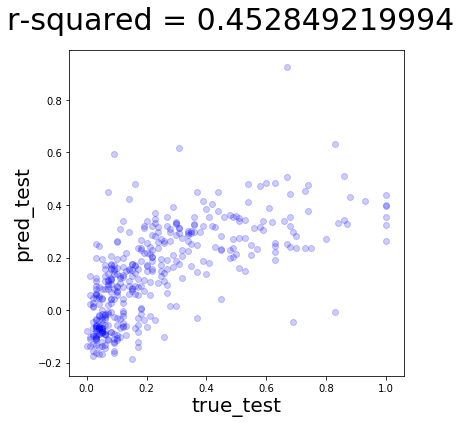

r-squared: 0.438026948689


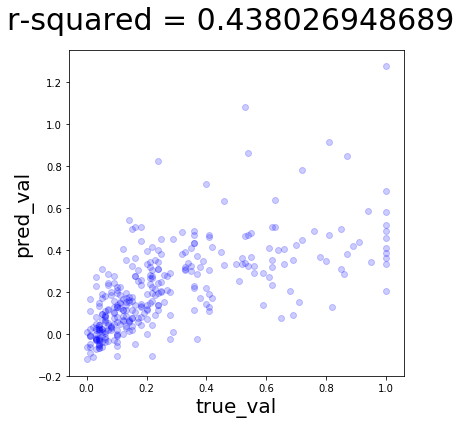

r-squared: 0.450380849654


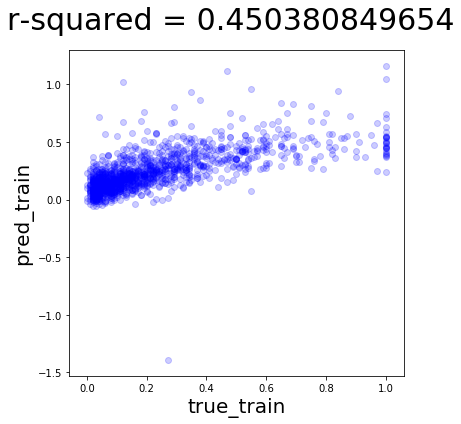

In [168]:
display(data.head())
print(r.best_params('val_r_value',ascending=True)[0])
#visualize the predict and truth and compute the r_squared
evaluate(activate_model(ta.Predict(t).scan_object, data.index[0]),x_train,y_train,x_val,y_val,x_test,y_test)

## 6. Data analysis

In [158]:
def summary(para_spaces,best_param_each_round,data_each_round,exp_round):
    for i in range(1,exp_round+1):
        print('para_spaces is ')
        print(para_spaces[i-1])
        print('best parameter in para sapces')
        print(best_param_each_round[i])
        print('data overview')
        display(data_each_round[i].head())

Based on the parameter space of p1 in section 3, we get r_squared 0.45 for train data and 0.37 for validation data. By trying p2, p3,... repeatring section 4 and 5. The log are stated below:


In [159]:
summary(para_spaces,best_param_each_round,data_each_round,exp_round)

para_spaces is 
{'first_neuron': [10], 'first_activation': ['relu'], 'hidden_layer': [3], 'hidden_neuron': [8], 'batch_size': [30], 'epochs': [40], 'kernel_initializer': ['normal'], 'optimizers': ['Adam'], 'losses': ['MSE'], 'activation': ['relu'], 'last_activation': ['linear']}
best parameter in para sapces
['Adam' '3' 'relu' '30' 'MSE' 'linear' '10' 'normal' '0.328454137596' '8'
 'relu' '40' 0]
data overview


,round_epochs,val_loss,val_r_value,loss,r_value,first_neuron,first_activation,hidden_layer,hidden_neuron,batch_size,epochs,kernel_initializer,optimizers,losses,activation,last_activation
0,40,0.0373607328319,0.328454137596,0.0242809072879,0.285700327919,10,relu,3,8,30,40,normal,Adam,MSE,relu,linear


In [135]:
best_param_each_round[2]
data_each_round[2].head()

,round_epochs,val_loss,val_r_value,loss,r_value,first_neuron,first_activation,hidden_layer,hidden_neuron,batch_size,epochs,kernel_initializer,optimizers,losses,activation,last_activation
10,40,0.0326181541556,0.272097966701,0.0256071976673,0.25427043858,12,relu,0,8,20,40,normal,Adam,MSE,relu,linear
18,40,0.0374322866373,0.313571309969,0.029418171619,0.320926208186,12,relu,2,8,40,40,normal,Adam,MSE,relu,linear
2,40,0.045776714673,0.378455562838,0.0263353726544,0.311069842046,12,relu,2,8,20,40,normal,Adam,MSE,relu,linear
23,40,0.0469325611187,0.409704926059,0.0320698132851,0.374600404114,6,relu,2,8,20,40,normal,Adam,MSE,relu,linear
19,40,0.0506708153223,0.415420830623,0.0289905337812,0.327832650233,6,relu,0,8,20,40,normal,Adam,MSE,relu,linear
